In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Flatten image and remove walls

In [3]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

# max_env_steps = 100

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3 ,),  # number of cells *3!!!
            dtype='uint8'
        )
        # self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

In [4]:
import gym

def to_coords(state):
    idx = state[0:-1:3]
    n = int(np.sqrt(len(idx)))
    for i in range(n):
        for j in range(n):
            k = n*i + j
            if (idx[k] == 10) or (idx[k] == 8):
                return np.array([i+1, j+1])
            

class CuriosityWrapper(gym.Wrapper):
    
    def __init__(self, env):
        self.grid_size = env.unwrapped.grid.encode().shape[0]
        self.max_visited_states = 100
        self.max_steps = 50
        self.visited_states = deque(maxlen=self.max_visited_states)
        super().__init__(env)
        
    def step(self, action):
        state = self.env.observation(self.env.unwrapped.gen_obs())
        next_state, _, _, info = self.env.step(action)
        
        if tuple(state) in self.visited_states:
            reward = -1
        else:
            reward = 1
            
        done = False
        
        if self.step_count >= self.max_steps:
            done = True
        
        self.visited_states.append(tuple(state))
            
        return next_state, reward, done, info
    
    def reset(self):
        self.visited_states = deque(maxlen=self.max_visited_states)
        return self.env.reset()
            

class RandomPosAndGoalWrapper(gym.Wrapper):
    
    def reset(self):
        
        # Generate goal state
        self.env.unwrapped.agent_pos = np.random.randint(1, self.grid_size-1, 2) 
        self.goal_state = self.env.observation(self.env.unwrapped.gen_obs())
        goal_pos = to_coords(self.goal_state)
        
        # Set initial state
        self.env.reset()
        radius = self.grid_size-2
        init_pos = (goal_pos + np.random.randint(0, radius, 2))%(self.grid_size-2) + 1
        while (init_pos==goal_pos).all():
            init_pos = (goal_pos + np.random.randint(0, radius, 2))%(self.grid_size-2) + 1
            
        self.env.unwrapped.agent_pos = init_pos
        
        # Return initial state 
        return self.env.observation(self.env.unwrapped.gen_obs())
    
    def __init__(self, env):
        self.goal_state = None
        self.grid_size = env.unwrapped.grid.encode().shape[0]
        super().__init__(env)
        
        
    def step(self, action):
        state = self.env.observation(self.env.unwrapped.gen_obs())
        next_state, reward, done, info = self.env.step(action)
        cur_pos, next_pos, goal_pos = to_coords(state), to_coords(next_state), to_coords(self.goal_state)
        dist1 = np.linalg.norm(cur_pos - goal_pos)
        dist2 = np.linalg.norm(next_pos - goal_pos)
        
        reward = (dist1 - dist2)
        reward = 1 - np.sqrt(2) if reward == 0 else reward
        
        if (next_pos == goal_pos).all() or (self.step_count  >= self.max_steps):
            done = True
        else: 
            done = False
        
        return next_state, reward, done, info
    
            
from gym.wrappers import Monitor

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    env = FlatObsWrapper(gym.make(env_name))
    env = RandomPosAndGoalWrapper(env)
    return wrap_env(env)

# Worker agent

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
from torch.distributions.multivariate_normal import MultivariateNormal

BATCH_SIZE = 128 # 128
UPDATE_STEP = 4 # 4
BUFFER_SIZE = 100000 # 100000
LEARNING_RATE = 5e-3 # 5e-3
GAMMA = 0.9 # 0.9
EPS_START = 1 # 1
EPS_END = 0.1 # 0.1
EPS_DECAY = 0.995 # 0.995
TAU=1e-3 # 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
    
    
class WorkerNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, action_size, emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(WorkerNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)    
        self.layer11 = nn.Linear(state_size, hidden_size1)
        self.layer12 = nn.Linear(state_size, emb_size)
        self.layer2 = nn.Linear(emb_size + hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, action_size)

    def forward(self, states, goal_states, emb=None):
        x = F.relu(self.layer11(states))
        if emb is None:
            emb = torch.tanh(self.layer12(goal_states))
        x = torch.cat((x, emb), 1)
        x = F.relu(self.layer2(x))
        return self.layer3(x)  
    


class DQNAgentWorker:
    """ An agent implementing Deep Q-Network algorithm"""
    
    def __init__(self, state_size, action_size, emb_size, seed=42):
        """Initializes an Agent.
        
        Params:
        -------
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.qnetwork_local = WorkerNetwork(state_size, action_size, emb_size=emb_size).to(device)
        self.qnetwork_target = WorkerNetwork(state_size, action_size, emb_size=emb_size).to(device)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)
        self.action_size = action_size
        self.buffer = deque(maxlen=BUFFER_SIZE) 
        self.step = 0
        self.eps = EPS_START
        self.explore = True
            
            
    def learn(self):
        """
        Learns values-actions network
        
        """
        
        # Sample batch from replay buffer
        states, next_states, goal_states, actions, rewards, dones = self.sample_batch()
            
        values = self.qnetwork_target.forward(next_states, goal_states).detach()
        targets = rewards + GAMMA * values.max(1)[0].view(dones.size()) * (1 - dones)
        outputs = self.qnetwork_local.forward(states, goal_states)
        outputs = outputs.gather(1, actions.long())
                
        self.optimizer.zero_grad()
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        self.optimizer.step()

            
            
    def update(self, state, goal_state, action, reward, next_state, done):
        """
        Makes an update step of algorithm and append sars to buffer replay
        
        Params:
        -------
        state - current state
        action - action made
        reward - reward for an action
        next_state - next state from env
        done - episode finishing flag
        """
        self.buffer.append((state, next_state, goal_state, action, reward, float(done)))
        
        self.step = (self.step+1)%UPDATE_STEP
        if self.step == 0:
            if len(self.buffer) > BATCH_SIZE:
                self.learn()
                self.reset_target_network()
        
        
    def reset_target_network(self):
        """
        Resets params of target network to values from local network
        """
        params = zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters())
        for target_param, local_param in params:
            updated_params = TAU*local_param.data + (1-TAU)*target_param.data
            target_param.data.copy_(updated_params)
        
        
    def act(self, state, goal_state=None, goal_emb=None):
        """
        Selects action from state if epsilon-greedy way
        
        Params:
        state - current state
        
        """
        
        
        self.step+=1
        
        self.qnetwork_local.eval()
        states = torch.from_numpy(np.vstack([state])).float().to(device)
        if goal_emb is not None:
            goal_embs = torch.from_numpy(np.vstack([goal_emb])).float().to(device)
            goal_states = None
        else:
            goal_states = torch.from_numpy(np.vstack([goal_state])).float().to(device)
            goal_embs = None
            
        with torch.no_grad():
            action_values = self.qnetwork_local.forward(states, goal_states, goal_embs)  
        self.qnetwork_local.train()
            
        action = np.argmax(action_values.cpu().data.numpy())
        
        if self.explore:
            if random.random() < self.eps:
                action = random.choice(np.arange(self.action_size))
            
        return action 
    
    
    def reset_episode(self):
        """
        Resets episode and update epsilon decay
        """
        self.eps = max(EPS_END, EPS_DECAY*self.eps) 
    
        
    def sample_batch(self, batch_size=BATCH_SIZE):
        """
        Samples a batch of experience from replay buffer random uniformily
        """
        batch = random.sample(self.buffer, k=batch_size)
        f = lambda arr: torch.from_numpy(np.vstack(arr)).float().to(device)
        states, next_states, goal_states, actions, rewards, dones = map(f, zip(*batch))
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        return states, next_states, goal_states, actions, rewards, dones

Running on device: cpu


# Master agent

In [6]:
from collections import deque
import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer():
    """
    Memory buffer for saving trajectories
    """
    
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.buffer_size = buffer_size
    
    def add(self, states, goal_states, rewards, next_states, dones):
        self.buffer.append((states, goal_states, rewards, next_states, dones))
        
    def sample(self, batch_size=BATCH_SIZE):
        batch = random.sample(self.buffer, k=batch_size)
        f = lambda arr: torch.from_numpy(np.vstack(arr)).float().to(device)
        states, goal_states, rewards, next_states, dones = map(f, zip(*batch))
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        return states, goal_states, rewards, next_states, dones
    
    def is_enough(self):
        return len(self.buffer) > self.batch_size

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
from torch.distributions.multivariate_normal import MultivariateNormal


LEARNING_RATE_ACTOR_MASTER = 1e-4
LEARNING_RATE_CRITIC_MASTER = 1e-4
GAMMA_MASTER = 0.99 
TAU_MASTER = 0.01
BATCH_SIZE_MASTER = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

    
class ActorNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """
    
    def __init__(self, state_size, emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, emb_size)


    def forward(self, states):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        return torch.tanh(self.layer3(x))
    
    
class CriticNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)    
        self.layer1 = nn.Linear(state_size , hidden_size1)
        self.layer2 = nn.Linear(hidden_size1 + emb_size, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, 1)

    def forward(self, states, goal_embs):
        x = F.relu(self.layer1(states))
        x = torch.cat((x, goal_embs), 1)
        x = F.relu(self.layer2(x))
        return F.relu(self.layer3(x))
    
    
class MasterNetwork(nn.Module):
    """
    Master-Worker model
    """
    
    def __init__(self, state_size, emb_size, seed=42):
        super(MasterNetwork, self).__init__()
        self.actor = ActorNetwork(state_size, emb_size)
        self.critic = CriticNetwork(state_size, emb_size)
        self.target_actor = ActorNetwork(state_size, emb_size)
        self.target_critic = CriticNetwork(state_size, emb_size)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=LEARNING_RATE_CRITIC_MASTER) 
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=LEARNING_RATE_ACTOR_MASTER)
    
    
    def update_actor(self, states):
        self.actor_optimizer.zero_grad()
        goal_states = self.actor.forward(states)
        loss = -self.critic.forward(states, goal_states).mean()
        loss.backward()
        self.actor_optimizer.step()
    
    
    def update_critic(self, states, goal_states, rewards, dones, next_states):
        self.critic_optimizer.zero_grad()
        next_goal_states = self.target_actor.forward(next_states)
        q_target = self.target_critic.forward(next_states, next_goal_states).detach()
        y = rewards + GAMMA_MASTER*(1-dones)*q_target
        q = self.critic.forward(states, goal_states)
        loss = F.mse_loss(q, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
        self.critic_optimizer.step()
        
    def update_target_networks(self):
        critic_params = zip(self.target_critic.parameters(), self.critic.parameters())
        for target_param, param in critic_params:
            updated_params = TAU_MASTER*param.data + (1-TAU_MASTER)*target_param.data
            target_param.data.copy_(updated_params)
            
        actor_params = zip(self.target_actor.parameters(), self.actor.parameters())
        for target_param, param in actor_params:
            updated_params = TAU_MASTER*param.data + (1-TAU_MASTER)*target_param.data
            target_param.data.copy_(updated_params)
    
    

class DDPGAgentMaster:
    """ An agent implementing Deep Q-Network algorithm"""
    
    def __init__(self, state_size, emb_size=64, seed=42):
        """Initializes an Agent.
        
        Params:
        -------
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.master_network = MasterNetwork(state_size, emb_size).to(device)
        self.state_size = state_size
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE_MASTER)
        self.iter = 0
        self.explore = True
        
        self.act_noise = 1
        self.noise_decay = 0.995
        self.min_noise = 0.01
    
    def sample_goal(self, state):
        
        s = torch.from_numpy(np.vstack([state])).float().to(device)
        goal_state = self.master_network.target_actor.forward(s)
        
        if self.explore:
            goal_state += self.act_noise*torch.randn(goal_state.size()).to(device)
            
        return  np.clip(goal_state.cpu().data.numpy(), -1, 1) 
        

    def update(self, states, goal_states, rewards, next_states, dones):
        
        self.replay_buffer.add(states, goal_states, rewards, next_states, dones)
        
        if (self.iter < UPDATE_STEP) or not self.replay_buffer.is_enough():
            self.iter += 1
            return 
        
        self.iter=0
        self._update_master()
        
    def reset_episode(self):
        self.act_noise = max(self.noise_decay*self.act_noise, self.min_noise)
        
                    
    def _update_master(self):
        states, goal_states, rewards, next_states, dones = self.replay_buffer.sample()
        self.master_network.update_critic(states, goal_states, rewards, dones, next_states)
        self.master_network.update_actor(states)
        self.master_network.update_target_networks()

Running on device: cpu


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def run_episode(env, worker_agent, master_agent=None, train_mode=True, show_steps=False):
    """
    A hepler function for running single episode
    """
    
    state = env.reset() 
    if not train_mode:
        if master_agent is None:
            print("From ", to_coords(state), "to", to_coords(env.goal_state))
    score = 0 
    done = False
    
    steps = 0
        
    
    while not done:
        if master_agent is None:
            goal_state = env.goal_state
            action = worker_agent.act(state, goal_state)
            next_state, reward, done, _ = env.step(action)
            worker_agent.update(state, goal_state, action, reward, next_state, done)
            state = next_state
            score += reward  
            steps+=1
        else:
            goal_emb = master_agent.sample_goal(state)
            state_ = state
            for _ in range(1):
                action = worker_agent.act(state, None, goal_emb)
                next_state, reward, done, _ = env.step(action)
                state = next_state
                score += reward  
                steps+=1
                if done:
                    break
            master_agent.update(state_, goal_emb, reward, next_state, done)

        if (not train_mode) and show_steps:
            img = env.render('rgb_array')
            plt.imshow(img);
            plt.show()
        
            
    if master_agent is None:
        worker_agent.reset_episode()
    else: 
        master_agent.reset_episode()
    env.close()
    
    if not train_mode:
        show_video()
    
    return score, steps

def run_episodes_and_display(env, worker_agent, master_agent=None, n_episodes=1000):
    """
    Runs a series of episode and display agent's performance
    """
    
    display_step = 100
    score = 0
    score_sum = 0
    scores = []
    steps = []
    for episode in range(1, n_episodes+1):
        score, step = run_episode(env, worker_agent, master_agent, train_mode=True)
        score_sum += score
        scores.append(score)
        steps.append(step)
        if episode%display_step==0:
            avg_score = score_sum/display_step
            print("Episode: {}. Average score: {}".format(episode, avg_score))
            score_sum = 0
            
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Max Score')
    plt.xlabel('Episode #')
    plt.show()
    
    fig = plt.figure()
    plt.plot(np.arange(len(steps)), steps)
    plt.ylabel('Steps')
    plt.xlabel('Episode #')
    plt.show()

# Learn worker

Episode: 100. Average score: -20.149749259907036
Episode: 200. Average score: -5.694175575867941
Episode: 300. Average score: -1.2229506256572196
Episode: 400. Average score: 0.3290910447462616
Episode: 500. Average score: 0.7982099847732268


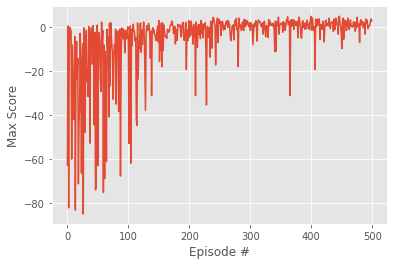

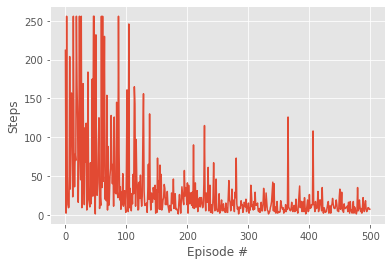

CPU times: user 46.7 s, sys: 480 ms, total: 47.1 s
Wall time: 47.1 s


In [9]:
%%time
env_name = 'MiniGrid-Empty-8x8-v0'
env = gen_wrapped_env(env_name)
state_size = env.observation_space.shape[0]
action_size = 3
emb_size = 32
worker_agent = DQNAgentWorker(state_size, action_size, emb_size)
run_episodes_and_display(env, worker_agent, n_episodes=500)

In [10]:
env = gen_wrapped_env(env_name)
worker_agent.explore = False
run_episode(env, worker_agent, train_mode=False, show_steps=False)

From  [5 4] to [6 2]


(1.8218544151266947, 4)

# Learn master

Episode: 100. Average score: 0.6756523437500003
Episode: 200. Average score: 0.8918632812499999
Episode: 300. Average score: 0.90391796875
Episode: 400. Average score: 0.9551406249999989
Episode: 500. Average score: 0.734296875


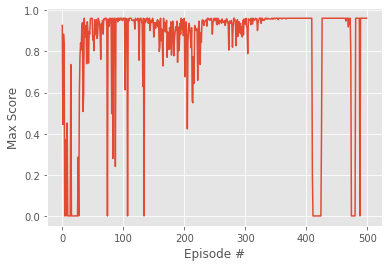

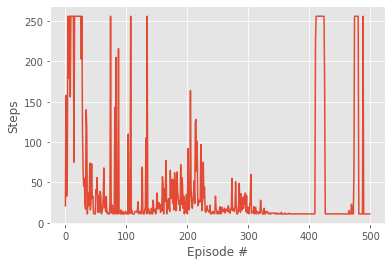

CPU times: user 40.4 s, sys: 449 ms, total: 40.8 s
Wall time: 40.8 s


In [13]:
%%time
env_name = 'MiniGrid-Empty-8x8-v0'
env = FlatObsWrapper(gym.make(env_name))
worker_agent.explore = False
master_agent = DDPGAgentMaster(state_size, emb_size)
run_episodes_and_display(env, worker_agent, master_agent, n_episodes=500)

In [12]:
env = FlatObsWrapper(gym.make(env_name))
#env = CuriosityWrapper(env)
env = Monitor(env, './video', force=True)
run_episode(env, worker_agent, master_agent, train_mode=False, show_steps=False)

(0.954296875, 13)